# Wiener Filter and LMS

This notebook walks through each filter and explains acquired results as necessary.

## Functions

### Import Dependencies

These are the packages I used throughout the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import csv
import os

### Utility

In [2]:
PLOT_DIR = "plots"

CSV_FILENAME = "all_results.csv"

if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

def plot_and_save(sig_true, sig_pred, figname, title="Comparison"):
    """
    Plots the true signal vs predicted, saves to figname.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(sig_true, label="Actual Output", alpha=0.7)
    plt.plot(sig_pred, label="Predicted Output", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, figname), dpi=150)

def plot_comparison(sig_input, sig_noisy, sig_pred, title="", max_pts=300):
    """
    Plots three signals in a single figure:
      1) Input signal
      2) Noisy/observed output
      3) Predicted output

    max_pts: number of samples to show (for clarity).
    """
    length = min(max_pts, len(sig_input), len(sig_noisy), len(sig_pred))
    plt.figure(figsize=(8,4))
    plt.plot(sig_input[:length], label="Input Signal", alpha=0.7)
    plt.plot(sig_noisy[:length], label="Noisy Output", alpha=0.7)
    plt.plot(sig_pred[:length], label="Predicted Output", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Signal Measurements

In [3]:
def unknown_plant(x):
    """
    H(z) = (1 - z^-10) / (1 - z^-1)
    y[n] = y[n-1] + x[n] - x[n-10].
    """
    N = len(x)
    y = np.zeros(N)
    for n in range(N):
        if n == 0:
            y[n] = x[n]
        elif n < 10:
            y[n] = y[n-1] + x[n]
        else:
            y[n] = y[n-1] + x[n] - x[n-10]
    return y

def add_noise(y, noise_var=0.1):
    """
    Add white Gaussian noise of variance = noise_var to y.
    """
    noise = np.sqrt(noise_var) * np.random.randn(len(y))
    return y + noise

def true_impulse_response(M=50):
    """
    Simulate impulse (x[0]=1, x[1..]=0) and measure the first M samples of y.
    This approximates the 'true' FIR of length M for H(z).
    """
    impulse = np.zeros(M*2)
    impulse[0] = 1.0
    h = np.zeros(M*2)
    for n in range(M*2):
        if n == 0:
            h[n] = impulse[n]
        elif n < 10:
            h[n] = h[n-1] + impulse[n]
        else:
            h[n] = h[n-1] + impulse[n] - impulse[n-10]
    return h[:M]

### Wiener Filter Calculations

In [4]:
def estimate_autocorr_matrix(x, M):
    """
    Estimate the MxM autocorrelation matrix R_xx from x.
    """
    N = len(x)
    r_xx_vec = np.zeros(M)
    for lag in range(M):
        r_xx_vec[lag] = np.sum(x[:N - lag] * x[lag:]) / (N - lag)
    R_xx = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            lag = abs(i - j)
            R_xx[i, j] = r_xx_vec[lag]
    return R_xx

def estimate_crosscorr(x, y, M):
    """
    Estimate cross-correlation vector r_xy of length M: r_xy[k] = E[x[n-k]*y[n]].
    """
    N = len(y)
    r_xy = np.zeros(M)
    for k in range(M):
        x_trunc = x[:N - k]
        y_shifted = y[k:]
        r_xy[k] = np.sum(x_trunc * y_shifted) / (N - k)
    return r_xy

def wiener_filter_solution(x, y, M, lam=0.0):
    """
    Solve Wiener filter w = (R_xx + lam*I)^-1 r_xy
    """
    R_xx = estimate_autocorr_matrix(x, M)
    r_xy = estimate_crosscorr(x, y, M)
    R_reg = R_xx + lam * np.eye(M)
    w = np.linalg.inv(R_reg).dot(r_xy)
    return w

def compute_weighted_snr(w_true, w_est):
    """
    Weighted SNR = 10 * log10( (w_true^T w_true) / ( (w_true - w_est)^T (w_true - w_est) ) ).
    """
    num = np.dot(w_true, w_true)
    den = np.dot(w_true - w_est, w_true - w_est)
    if den < 1e-15:
        return 999.0
    return 10.0 * np.log10(num / den)

### Least Mean Square Filter Calculations

In [5]:
def lms_filter(x_in, y_noisy, M, mu):
    """
    Basic LMS for system ID. Returns final filter after N updates.
    """
    N = len(x_in)
    w_lms = np.zeros(M)
    y_hat = np.zeros(N)
    for n in range(N):
        x_vec = np.zeros(M)
        for m in range(M):
            idx = n - m - 1
            if idx >= 0:
                x_vec[m] = x_in[idx]
        y_hat[n] = np.dot(w_lms, x_vec)
        e = y_noisy[n] - y_hat[n]
        w_lms += mu * e * x_vec
    return w_lms, y_hat

### Speech Prediction

In [6]:
def wiener_predictor_blockwise(x, window_size, M, overlap=0.5, lam=1e-6):
    """
    Predict x[n+1] from x[n], x[n-1], ... x[n-M+1], in blocks with overlap.
    Returns y_pred & w_history.
    """
    step = int(window_size * overlap)
    N = len(x)
    y_pred = np.zeros(N)
    w_history = []

    start = 0
    while True:
        end = start + window_size
        if end > N:
            end = N
        block_x = x[start:end]

        block_len = len(block_x) - 1
        if block_len <= M:
            break

        Xmat = np.zeros((block_len, M))
        d = np.zeros(block_len)
        for n in range(block_len):
            d[n] = block_x[n+1]
            for m in range(M):
                idx = n - m
                if idx >= 0:
                    Xmat[n, m] = block_x[idx]

        R_xx = (Xmat.T @ Xmat) / block_len
        r_xd = (Xmat.T @ d) / block_len
        w = np.linalg.inv(R_xx + lam * np.eye(M)) @ r_xd
        w_history.append(w)

        pred_block = Xmat @ w
        for n in range(block_len):
            global_idx = start + n + 1
            if global_idx < N:
                y_pred[global_idx] = pred_block[n]

        if end == N:
            break
        start += step
        if start >= N:
            break

    return y_pred, w_history

def lms_predictor(x, M, mu=0.01):
    """
    Single-pass LMS predictor: predict x[n+1].
    Returns (y_pred, final filter).
    """
    N = len(x)
    w = np.zeros(M)
    y_pred = np.zeros(N)
    for n in range(N-1):
        x_vec = np.zeros(M)
        for m in range(M):
            idx = n - m
            if idx >= 0:
                x_vec[m] = x[idx]
        y_hat = np.dot(w, x_vec)
        y_pred[n+1] = y_hat
        e = x[n+1] - y_hat
        w += mu * e * x_vec
    return y_pred, w

### Filter Cross-Validation

In [7]:
def cross_validation_wiener(x, y, M, lam_candidates, train_ratio=0.8):
    """
    Splits data into train/validation by 'train_ratio'.
    For each candidate lam, fit Wiener filter on train set, 
    measure MSE on validation set, and pick best lam.
    Returns best_lam.
    """
    N = len(x)
    split = int(train_ratio * N)
    x_train = x[:split]
    y_train = y[:split]
    x_val   = x[split:]
    y_val   = y[split:]
    
    best_lam = lam_candidates[0]
    best_mse = 1e15
    for lam_c in lam_candidates:
        w_est_c = wiener_filter_solution(x_train, y_train, M, lam_c)
        val_len = len(x_val)
        y_hat_val = np.zeros(val_len)
        for i in range(val_len):
            x_vec = np.zeros(M)
            for mm in range(M):
                idx = i - mm
                if idx >= 0:
                    x_vec[mm] = x_val[idx]
            y_hat_val[i] = np.dot(w_est_c, x_vec)
        mse_val = np.mean((y_val - y_hat_val)**2)
        if mse_val < best_mse:
            best_mse = mse_val
            best_lam = lam_c
    return best_lam

def cross_validation_lms(x, y, M, eta_candidates, train_ratio=0.8):
    """
    Splits data into train/validation by 'train_ratio'.
    For each candidate eta, adapt on train set, optionally 
    continue adaptation on val, or just measure MSE on val.
    Returns best_eta.
    """
    N = len(x)
    split = int(train_ratio * N)
    x_train = x[:split]
    y_train = y[:split]
    x_val   = x[split:]
    y_val   = y[split:]
    
    best_eta = eta_candidates[0]
    best_mse = 1e15
    for eta_c in eta_candidates:
        # Train
        w_lms = np.zeros(M)
        for n in range(len(x_train)):
            x_vec = np.zeros(M)
            for mm in range(M):
                idx = n - mm
                if idx >= 0:
                    x_vec[mm] = x_train[idx]
            y_hat = np.dot(w_lms, x_vec)
            e = y_train[n] - y_hat
            w_lms += eta_c * e * x_vec
        
        # Validate
        w_val = w_lms.copy()
        val_len = len(x_val)
        y_hat_val = np.zeros(val_len)
        for i in range(val_len):
            x_vec = np.zeros(M)
            for mm in range(M):
                idx = i - mm
                if idx >= 0:
                    x_vec[mm] = x_val[idx]
            y_hat_val[i] = np.dot(w_val, x_vec)
            e_val = y_val[i] - y_hat_val[i]
            # optional: continue adaptation if desired
            w_val += eta_c * e_val * x_vec
        
        mse_val = np.mean((y_val - y_hat_val)**2)
        if mse_val < best_mse:
            best_mse = mse_val
            best_eta = eta_c
    
    return best_eta

### Load Data & Constants

In [8]:
# Load your input signals (update if needed)
x_sine = np.load("sine.npy")
x_chirp = np.load("chirp.npy")

# Example parameters
noise_variances = [0.1, 0.3, 1.5]
model_orders = [5, 15, 50]
window_sizes = [100, 500, 5000]
lambda_candidates = [0.0, 1e-6, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0]

# True IR reference up to 50 taps
w_true_full = true_impulse_response(M=50)

## Part 1

### Wiener Filter

#### A) Model Order Relevance & $\lambda$ Choice


=== SINE Input ===
  Noise variance=0.1
    M=5, best_lam=0.003, W-SNR=0.30 dB, NMSE=0.2109


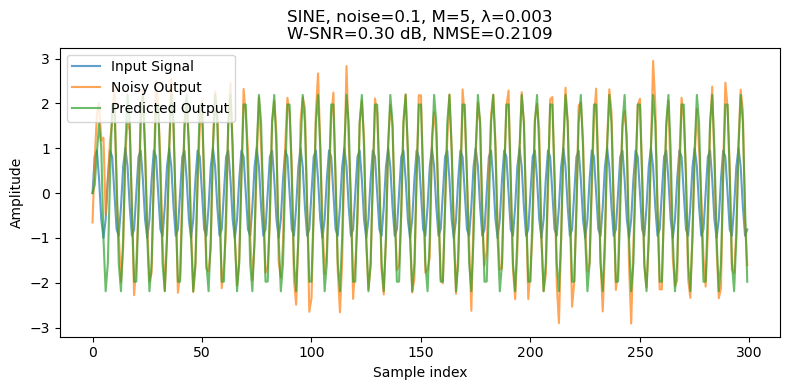

    M=15, best_lam=0.1, W-SNR=0.32 dB, NMSE=0.2121


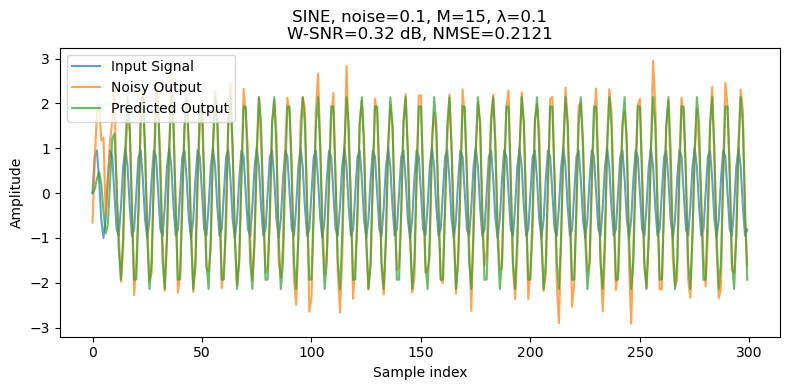

    M=50, best_lam=0.3, W-SNR=0.09 dB, NMSE=0.2325


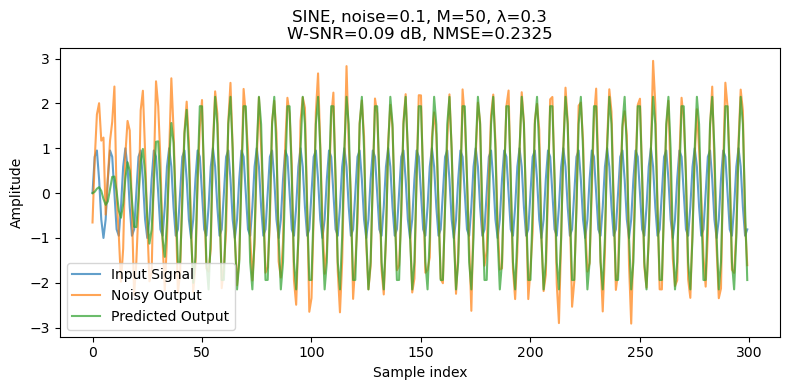

  Noise variance=0.3
    M=5, best_lam=0.01, W-SNR=0.53 dB, NMSE=0.6138


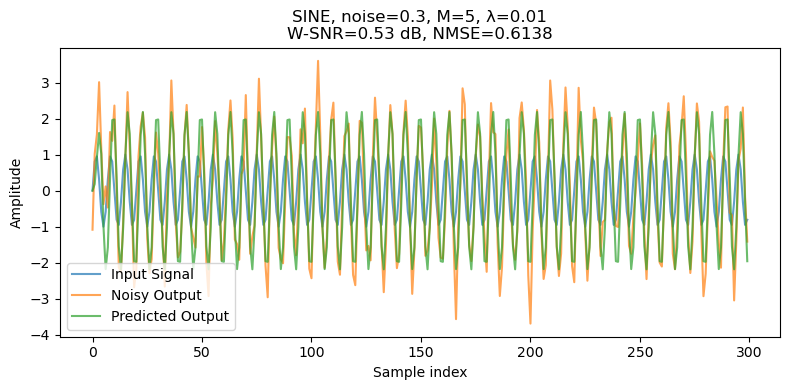

    M=15, best_lam=0.03, W-SNR=0.40 dB, NMSE=0.6158


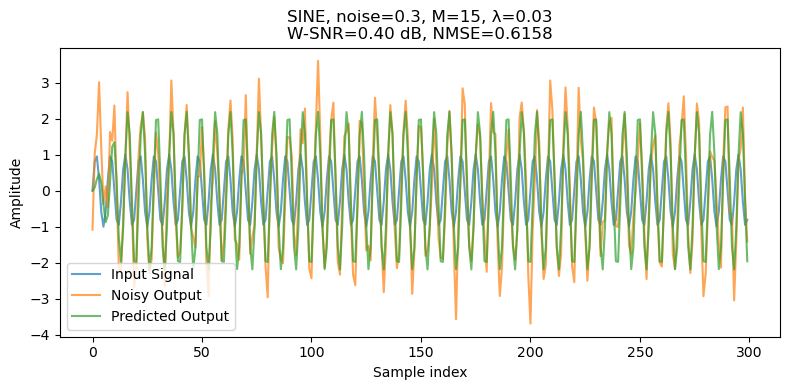

    M=50, best_lam=0.1, W-SNR=0.11 dB, NMSE=0.6431


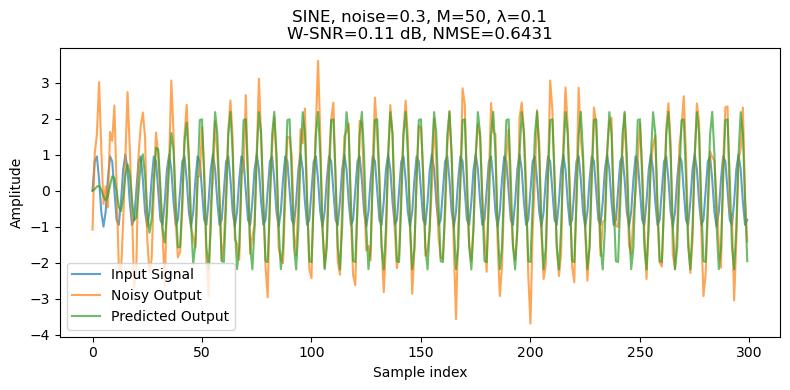

  Noise variance=1.5
    M=5, best_lam=1e-06, W-SNR=0.73 dB, NMSE=3.1724


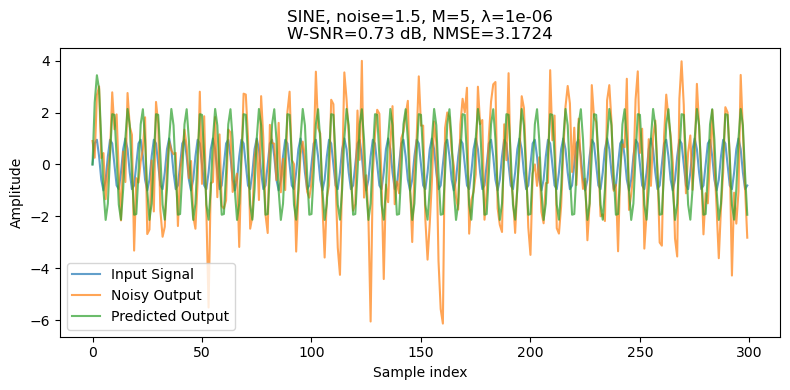

    M=15, best_lam=0.3, W-SNR=0.30 dB, NMSE=3.2034


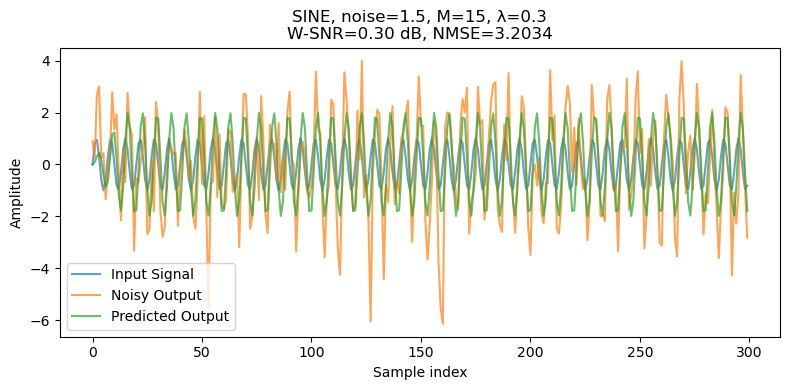

    M=50, best_lam=1.0, W-SNR=0.08 dB, NMSE=3.2159


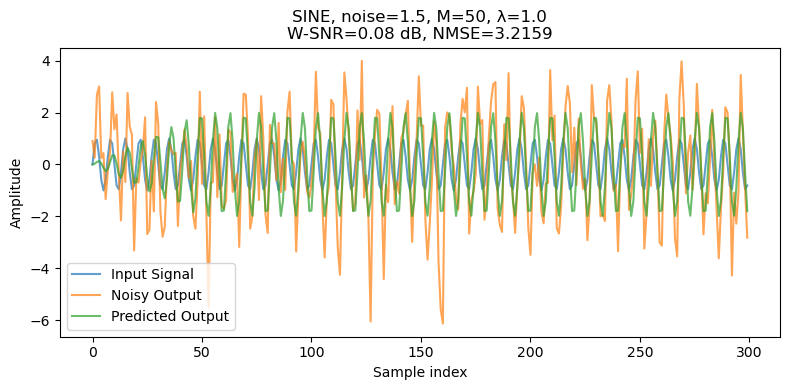


=== CHIRP Input ===
  Noise variance=0.1
    M=5, best_lam=0.0, W-SNR=21.52 dB, NMSE=5.5273


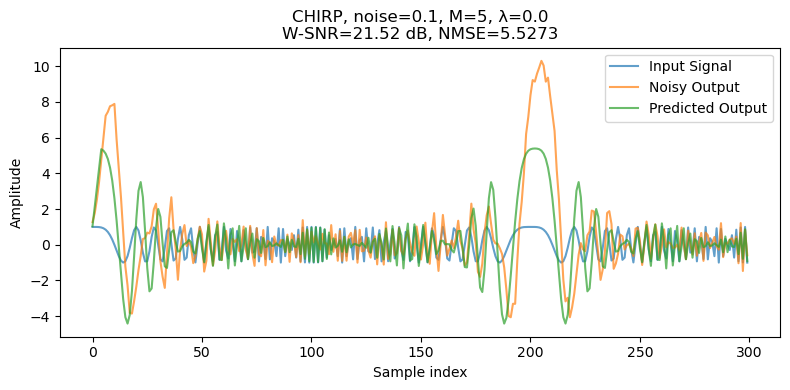

    M=15, best_lam=0.0, W-SNR=35.00 dB, NMSE=0.1982


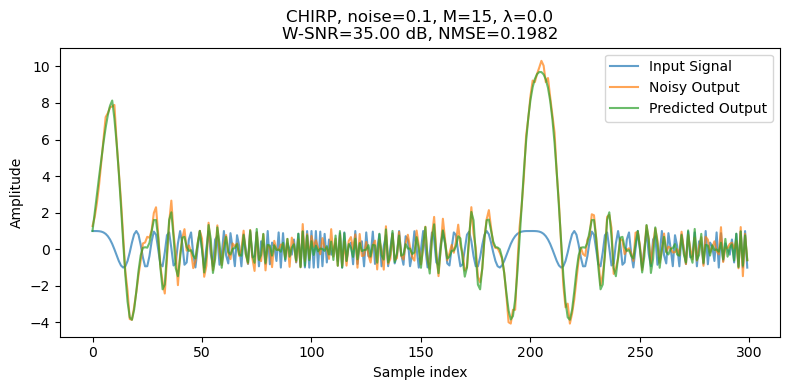

    M=50, best_lam=0.0, W-SNR=28.22 dB, NMSE=0.1980


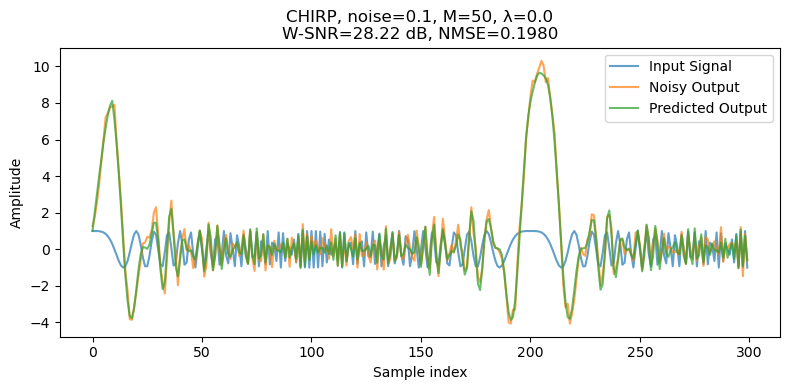

  Noise variance=0.3
    M=5, best_lam=0.001, W-SNR=21.47 dB, NMSE=5.8496


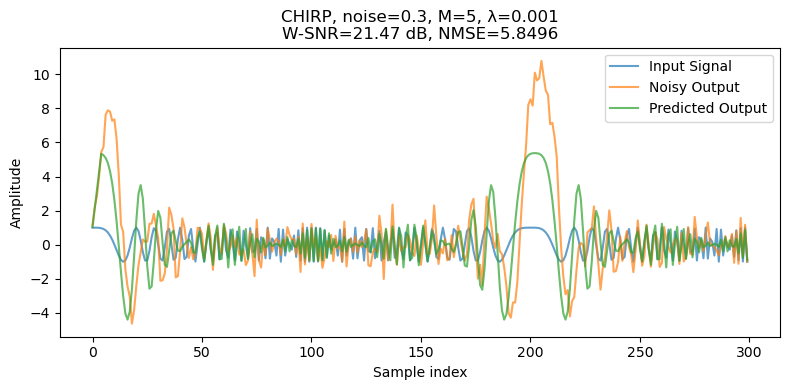

    M=15, best_lam=0.0, W-SNR=31.01 dB, NMSE=0.5348


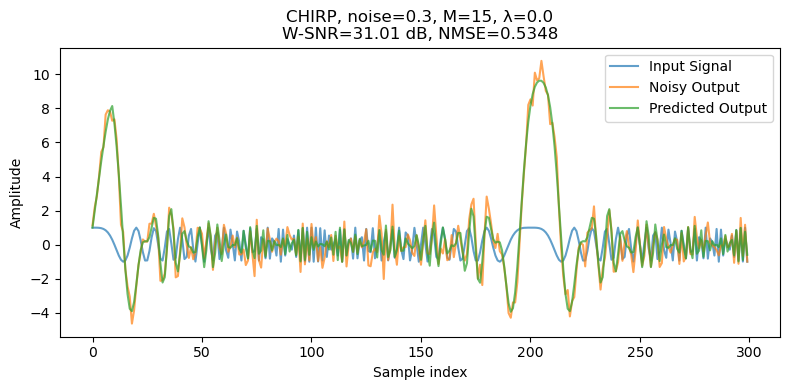

    M=50, best_lam=0.0, W-SNR=25.15 dB, NMSE=0.5271


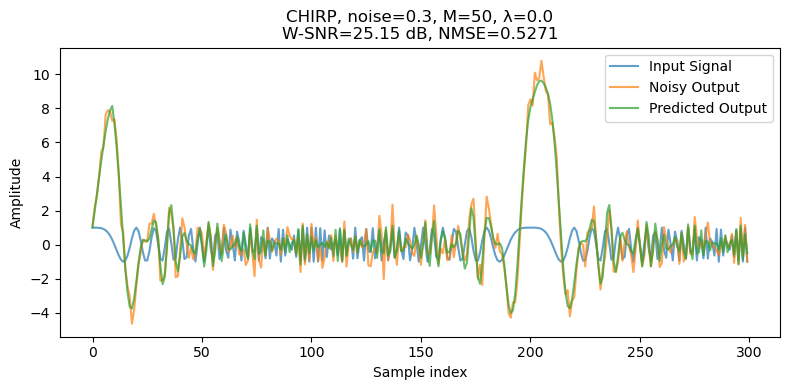

  Noise variance=1.5
    M=5, best_lam=0.0, W-SNR=23.90 dB, NMSE=7.8370


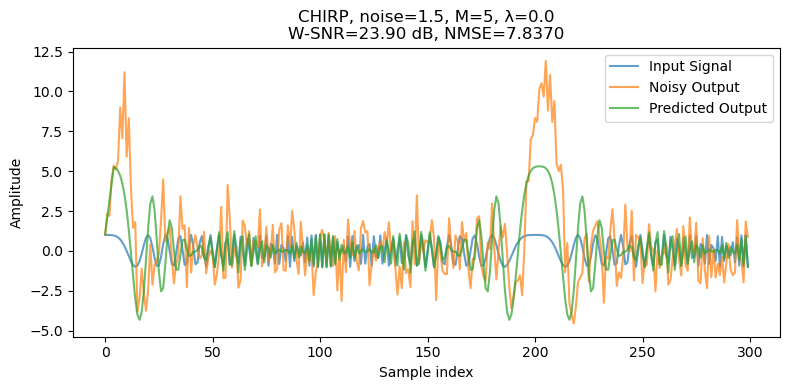

    M=15, best_lam=0.0, W-SNR=25.45 dB, NMSE=2.6563


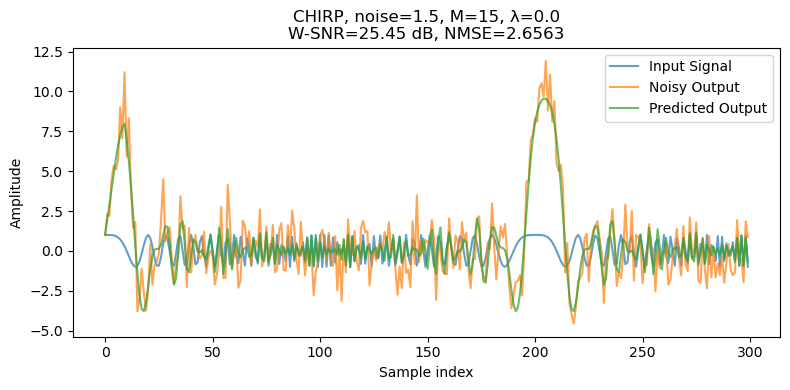

    M=50, best_lam=0.0, W-SNR=20.28 dB, NMSE=2.6041


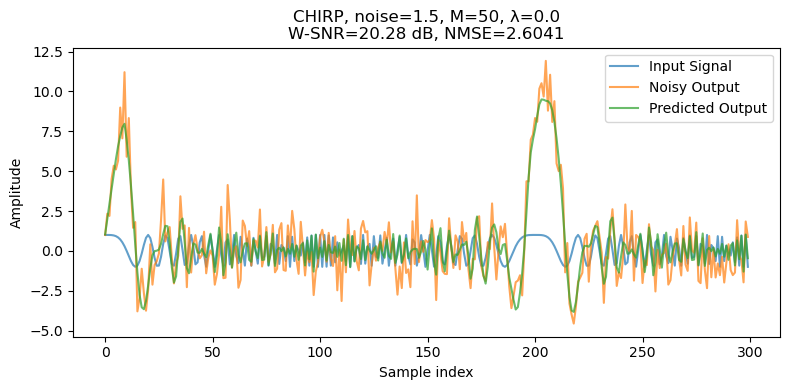


Average best lambda: 0.102444


In [9]:
best_lams = []
for input_name, x_in in zip(["sine", "chirp"], [x_sine, x_chirp]):
    print(f"\n=== {input_name.upper()} Input ===")
    # Pass input through plant (noise-free)
    y_clean = unknown_plant(x_in)
    N = len(x_in)
    
    for nv in noise_variances:
        # Add noise to the plant output
        y_noisy = add_noise(y_clean, noise_var=nv)
        print(f"  Noise variance={nv}")
        
        for M in model_orders:
            # For demonstration, let's pick a single window size = 2000
            W = min(N, 2000)
            
            # Slice the input and noisy output
            x_w = x_in[:W]
            y_w = y_noisy[:W]
            
            # Cross-validate lambda
            best_lam = cross_validation_wiener(x_w, y_w, M, lambda_candidates, train_ratio=0.8)
            best_lams.append(best_lam)
            
            # Final Wiener solution
            w_est = wiener_filter_solution(x_w, y_w, M, best_lam)
            
            # Compute Weighted SNR
            w_true_trunc = w_true_full[:M]
            w_snr = compute_weighted_snr(w_true_trunc, w_est)
            
            # Evaluate predicted output y_hat
            y_hat = np.zeros(W)
            for i in range(W):
                x_vec = np.zeros(M)
                for mm in range(M):
                    idx = i - mm
                    if idx >= 0:
                        x_vec[mm] = x_w[idx]
                y_hat[i] = np.dot(w_est, x_vec)
            
            # NMSE
            nmse = np.mean((y_w - y_hat)**2) / (np.mean(x_w**2) + 1e-14)
            print(f"    M={M}, best_lam={best_lam}, "
                  f"W-SNR={w_snr:.2f} dB, NMSE={nmse:.4f}")
            
            # Plot all three signals: input, noisy output, predicted
            plot_comparison(
                sig_input=x_w,
                sig_noisy=y_w,
                sig_pred=y_hat,
                title=(f"{input_name.upper()}, noise={nv}, "
                       f"M={M}, λ={best_lam}\n"
                       f"W-SNR={w_snr:.2f} dB, NMSE={nmse:.4f}"),
                max_pts=300
            )

# Average of best_lams
avg_best_lam = np.mean(best_lams)
print(f"\nAverage best lambda: {avg_best_lam:.6f}")

The code above reports the W-SNR and NMSE values per input signal, and evaluate the best $\lambda$ value based on **normalized** MSE.

##### Model Order

For both inputs, model order clearly impacts the model's performance. An interesting trend actually is that as model order increases past a certain amount, NMSE stays relatively stagnant, but W-SNR seems to be impacted significantly. However, it is still clear from both models that insufficient model order can be problematic, while excessive model order is simply unnecessary.

For either signal, it seems that a significant amount of regularization was not particularly necessary, both tending towards small (or 0) $\lambda$ values. In either case, the average $\lambda$ value was closest to 0.03, so the next experiments will be based on that value. 

#### Noise Levels

For both inputs, 
$
\frac{\partial \text{WSNR}}{\partial \sigma^2_{\text{noise}}} < 0 \quad \text{and} \quad \frac{\partial \text{NMSE}}{\partial \sigma^2_{\text{noise}}} > 0. \text{ or }
\sigma^2_{\text{noise}} \uparrow \quad \Rightarrow \quad \text{WSNR} \downarrow \quad \text{and} \quad \text{NMSE} \uparrow
$
. While this relationship held, it was still particularly robust to the noise - the graphs indicate that the model was following general trends for both input signals.

##### Individual Signal Performance & Comments

I expected the model to learn the filter for the sine function well since its statistical properties are stationary, however the chirp function is not stationary. The Wiener filter easily learned the filter for the sinusoid, whose spectral power spectrum is concentrated on one frequency. In contrast, the Wiener Filter struggled a bit more to learn the filter for the chirp - its power spectrum is more diverse, likely causing the difficulties, however the chirp signal itself is still periodic which filters are known to handle. 

#### B) Train model w/ different Windows, Compare & Explain results

In [10]:
# Example: picking different windows in the time series
# Let's demonstrate with chirp, M=15, noise=0.1
x_in = x_chirp
y_c = unknown_plant(x_in)

M_demo = 15
window_length = 1000
num_windows = 10
step = (len(x_in) - window_length)//(num_windows-1)

avg_avg_w_snr = 0.0
lam = 0.03
for trial in range(10):
    y_c_noisy = add_noise(y_c, noise_var=0.1)

    avg_w_snr = 0.0
    for w_i in range(num_windows):
        start_idx = w_i * step
        end_idx = start_idx + window_length
        x_win = x_in[start_idx:end_idx]
        y_win = y_c_noisy[start_idx:end_idx]
        w_est_win = wiener_filter_solution(x_win, y_win, M_demo, lam)
        w_snr_win = compute_weighted_snr(w_true_full[:M_demo], w_est_win)
        avg_w_snr += w_snr_win/num_windows
    print(f"Trial {trial} Average W-SNR over windows: {avg_w_snr:.2f} dB")
    avg_avg_w_snr += avg_w_snr/10

print(f"Average W-SNR over windows & trials: {avg_avg_w_snr:.2f} dB")


Trial 0 Average W-SNR over windows: 23.35 dB
Trial 1 Average W-SNR over windows: 22.91 dB
Trial 2 Average W-SNR over windows: 23.35 dB
Trial 3 Average W-SNR over windows: 23.13 dB
Trial 4 Average W-SNR over windows: 22.88 dB
Trial 5 Average W-SNR over windows: 22.90 dB
Trial 6 Average W-SNR over windows: 23.34 dB
Trial 7 Average W-SNR over windows: 23.00 dB
Trial 8 Average W-SNR over windows: 23.11 dB
Trial 9 Average W-SNR over windows: 23.27 dB
Average W-SNR over windows & trials: 23.12 dB


It was shown pretty clearly that the data window location did not massively impact the model's ability to correctly learn the filter - They all hovered around the average of about 23 dB. This is a nice result because it suggests that the data is roughly *ergodic*, which is the assumption that we made when creating these models in the first place.

### Least Mean Square Filter

(Only using chirp)

#### A) Model Order Relevance & $\eta$ Choice


[LMS] Noise var=0.1
  M=5, after 10 trials => Best Trial #2, eta=0.1, W-SNR=8.72 dB, NMSE=2.2610


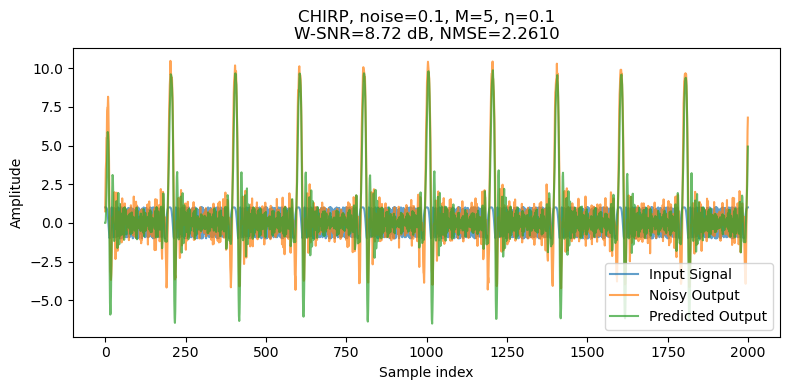

  M=15, after 10 trials => Best Trial #4, eta=0.0316, W-SNR=8.62 dB, NMSE=0.8442


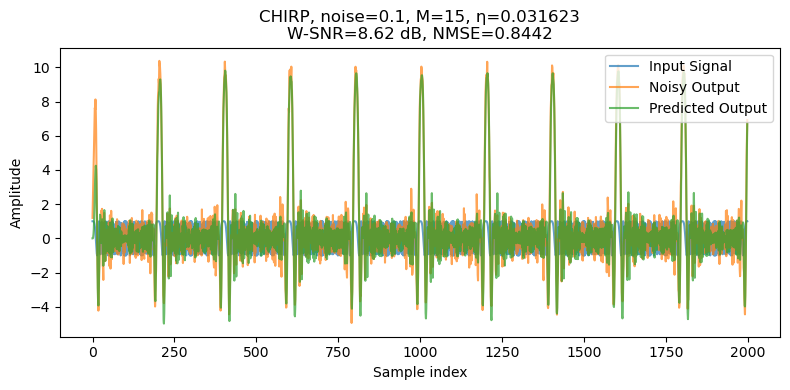

  M=50, after 10 trials => Best Trial #8, eta=0.00178, W-SNR=9.37 dB, NMSE=1.6220


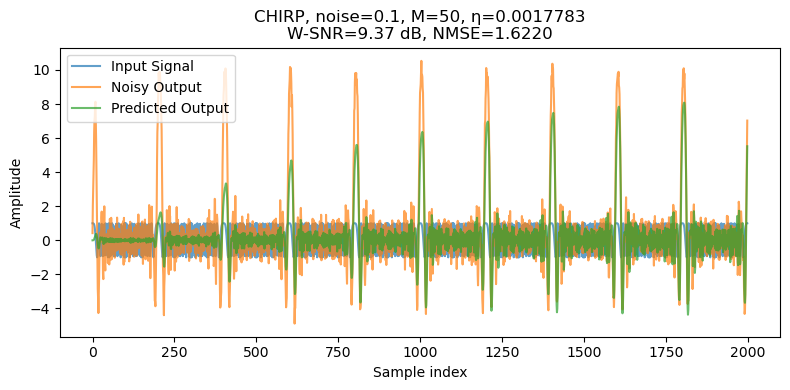


[LMS] Noise var=0.3
  M=5, after 10 trials => Best Trial #0, eta=0.1, W-SNR=6.20 dB, NMSE=2.6844


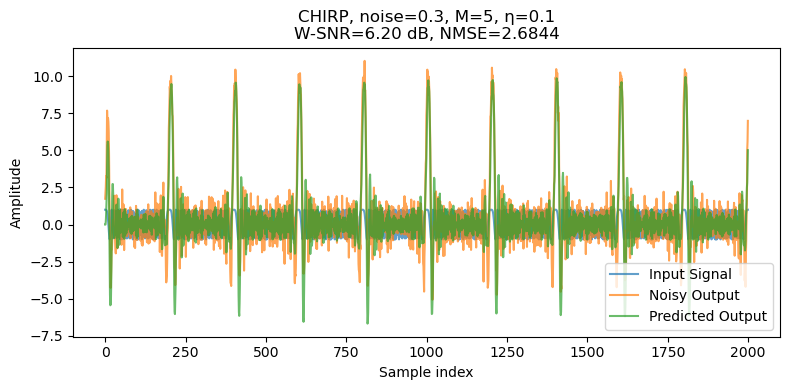

  M=15, after 10 trials => Best Trial #4, eta=0.00562, W-SNR=9.44 dB, NMSE=1.7304


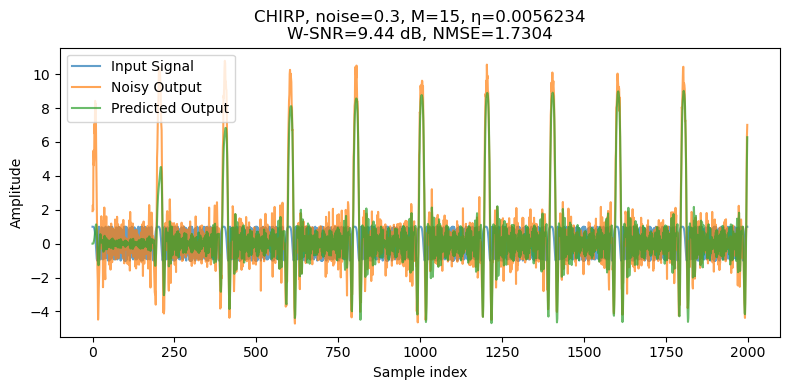

  M=50, after 10 trials => Best Trial #9, eta=0.00178, W-SNR=9.56 dB, NMSE=1.9656


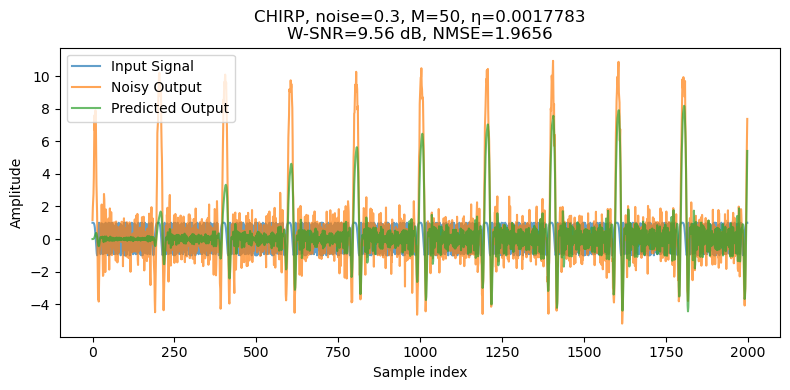


[LMS] Noise var=1.5
  M=5, after 10 trials => Best Trial #2, eta=0.1, W-SNR=6.87 dB, NMSE=5.2021


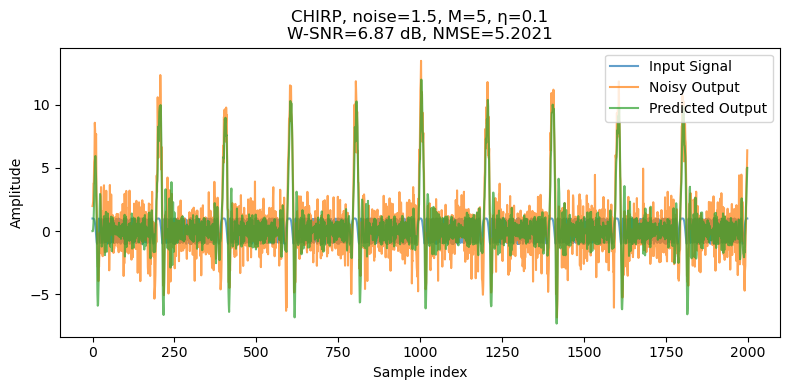

  M=15, after 10 trials => Best Trial #8, eta=0.001, W-SNR=10.01 dB, NMSE=4.5903


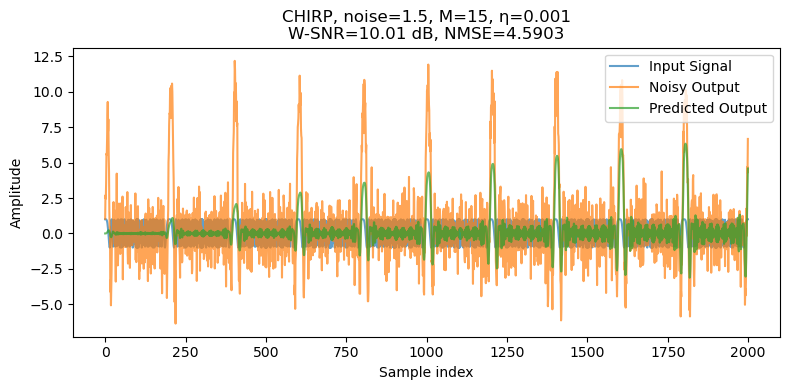

  M=50, after 10 trials => Best Trial #3, eta=0.001, W-SNR=9.11 dB, NMSE=4.6266


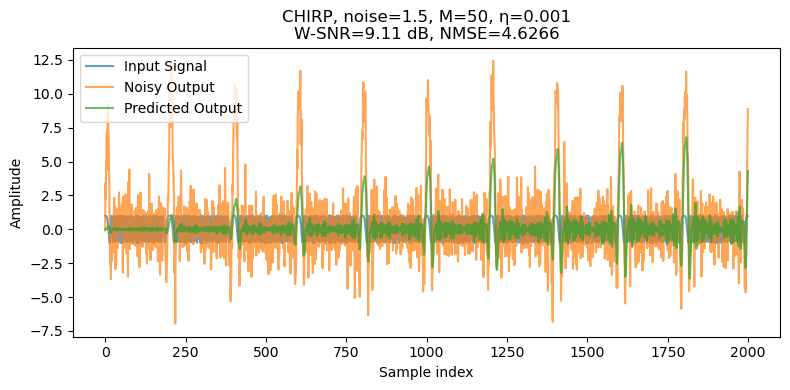

In [11]:
K = 10  # Number of trials
eta_candidates = [
    1e-4, 1.7783e-4, 3.1623e-4, 5.6234e-4, 1e-3, 
    1.7783e-3, 3.1623e-3, 5.6234e-3, 1e-2, 1.7783e-2, 
    3.1623e-2, 5.6234e-2, 1e-1
]

# We'll store scenario results in a dictionary if needed.
scenario_best_results = {}

N_ch = len(x_chirp)

for nv in noise_variances:
    print(f"\n[LMS] Noise var={nv}")
    
    for M in model_orders:
        # We'll track the best (lowest) NMSE across K trials:
        best_nmse_so_far = 1e15
        best_trial_index = None
        best_eta_for_scenario = None
        best_w_lms_for_scenario = None
        best_wsnr_for_scenario = None
        best_y_hat_for_scenario = None
        best_noisy_for_scenario = None
        
        for trial_i in range(K):
            # Optionally set a seed for reproducibility:
            # np.random.seed(trial_i)
            x_ch = x_chirp.copy()
            y_clean_ch = unknown_plant(x_ch)

            # Generate a new noisy signal each trial
            y_ch_noisy_this_trial = add_noise(y_clean_ch, noise_var=nv)
            
            # Cross-validate step size for this noisy signal
            best_eta = cross_validation_lms(
                x_ch, y_ch_noisy_this_trial, M, eta_candidates, train_ratio=0.8
            )
            
            # Train final on entire data with the best_eta
            w_lms_final, y_hat_lms= lms_filter(x_ch, y_ch_noisy_this_trial, M, best_eta)
            
            # Compute Weighted SNR
            w_true_trunc = w_true_full[:M]
            w_snr_lms = compute_weighted_snr(w_true_trunc, w_lms_final)
            
            # Compute NMSE
            nmse_lms = np.mean((y_ch_noisy_this_trial - y_hat_lms)**2) / (np.mean(x_ch**2)+1e-14)
            
            # Check if this trial is the best so far
            if nmse_lms < best_nmse_so_far:
                best_nmse_so_far = nmse_lms
                best_trial_index = trial_i
                best_eta_for_scenario = best_eta
                best_w_lms_for_scenario = w_lms_final.copy()
                best_wsnr_for_scenario = w_snr_lms
                best_noisy_for_scenario = y_ch_noisy_this_trial.copy()
                best_y_hat_for_scenario = y_hat_lms.copy()
        
        # After K trials, store the scenario's best results
        scenario_best_results[(nv, M)] = {
            "best_trial_index": best_trial_index,
            "best_eta": best_eta_for_scenario,
            "best_nmse": best_nmse_so_far,
            "best_wsnr": best_wsnr_for_scenario,
            "best_w_lms": best_w_lms_for_scenario,
            "best_noisy_signal": best_noisy_for_scenario,
            "best_predicted": best_y_hat_for_scenario
        }
        
        # Print summary
        print(f"  M={M}, after {K} trials => Best Trial #{best_trial_index}, "
              f"eta={best_eta_for_scenario:.3g}, W-SNR={best_wsnr_for_scenario:.2f} dB, "
              f"NMSE={best_nmse_so_far:.4f}")
        
        # Now plot the best trial's *actual noisy signal* vs. *predicted output*:

        plot_comparison(
            sig_input=x_w,
            sig_noisy=best_noisy_for_scenario,
            sig_pred=best_y_hat_for_scenario,
            title=(f"{input_name.upper()}, noise={nv}, "
                    f"M={M}, η={best_eta_for_scenario}\n"
                    f"W-SNR={best_wsnr_for_scenario:.2f} dB, NMSE={best_nmse_so_far:.4f}"),
            max_pts=2000
        )

The code above reports the W-SNR and NMSE values, evaluated on the best achieved NMSE and $\eta$ over 10 trials.

##### Model Order and Noise Level

Model order clearly impacts the model's performance. Much like the Wiener Filter, LMS's NMSE remains relatively stagnant past a model order threshold, and W-SNR improves with model order. Again, the model still suffers from insufficient expression and overfitting like the Wiener Filer.

Through cross-validation, it was roughly true that $\text{Model Order} \propto \frac{1}{\eta}$. 

##### Compare Accuracy w/ Wiener Filter (end of data window)

It seems that the model is capable of learning the data, but is highly dependent on the model order and $\eta$ values. Visually speaking, the model approaches the optimal representation early on, but is stable especially near the end of the data window, indicating that the time-series data was in fact learned.

##### Compare Computational Compelxity w/ Wiener Filter

Computationally Speaking, the Wiener Filter is:

$\mathcal{O}(NK^2)$ with $N$ being the data window size and $K$ being the Model order - while there are more operations than this, computing the auto-correlation matrix is definitely the most computationally demanding, especially when $N \gg K$. 

In contrast, the LMS Filter is only $\mathcal{O}(M)$ with $M$ being the model order - this is a drastic improvement in processing power consumption. The main tradeoff between the two is the Wiener Filter's "instant" learning vs the LMS Filter's "slow" learning, and the necessary computing power to support this. 

## Part 2

In [12]:
speech_data, fs_speech = sf.read("speech.WAV") 
speech_data = speech_data.astype(np.float64)
N_speech = len(speech_data)
print(f"Loaded speech: length={N_speech} samples, fs={fs_speech} Hz")

# The assignment says:
#  - Use filters of order 6 and 15
#  - Use windows of size 150 and 500
#  - 50% overlap, i.e. overlap=0.5
#  - Evaluate normalized error power (NMSE) and study weight tracks

speech_filter_orders = [6, 15]
speech_window_sizes = [150, 500]

Loaded speech: length=18176 samples, fs=10000 Hz


### Wiener Filter

[Speech-Wiener] window=150, M=6, NMSE=0.0608


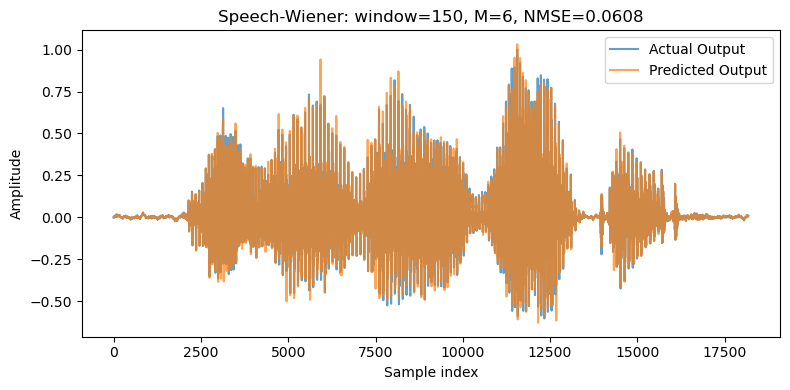

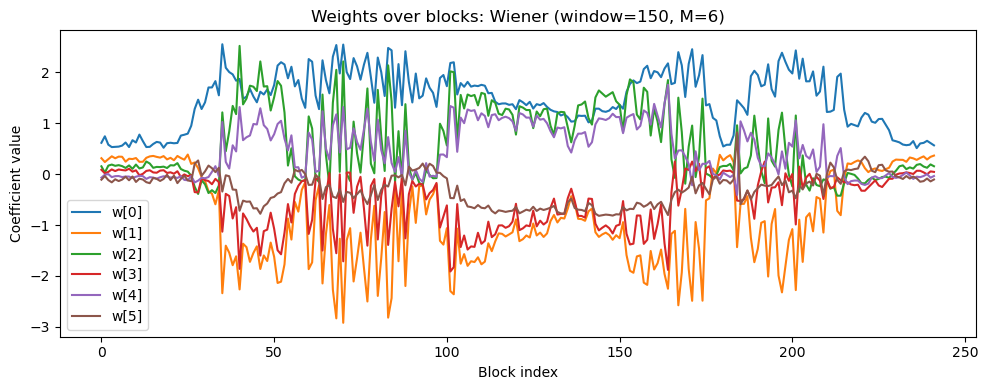

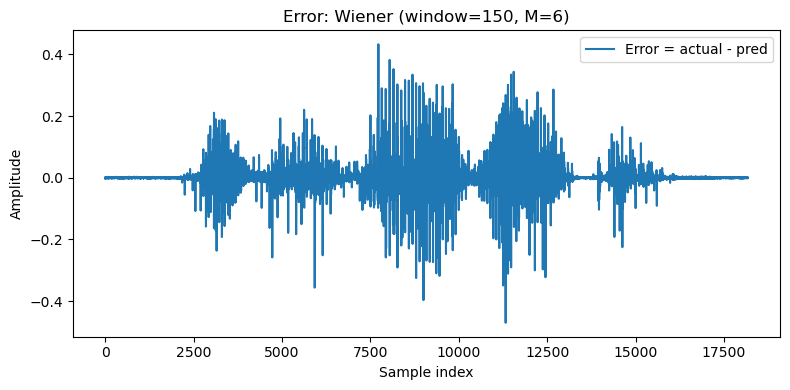

[Speech-Wiener] window=150, M=15, NMSE=0.0433


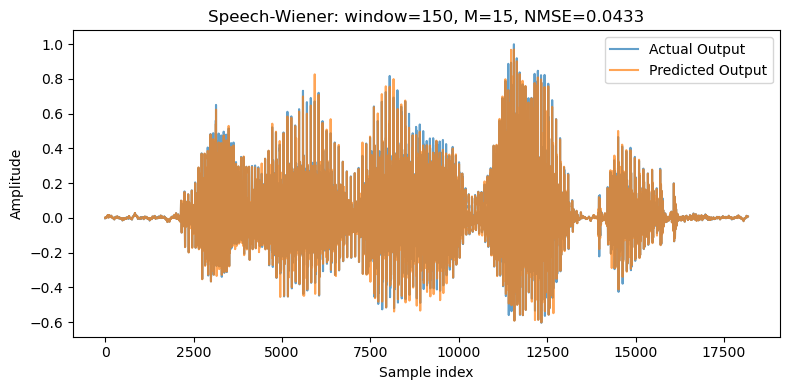

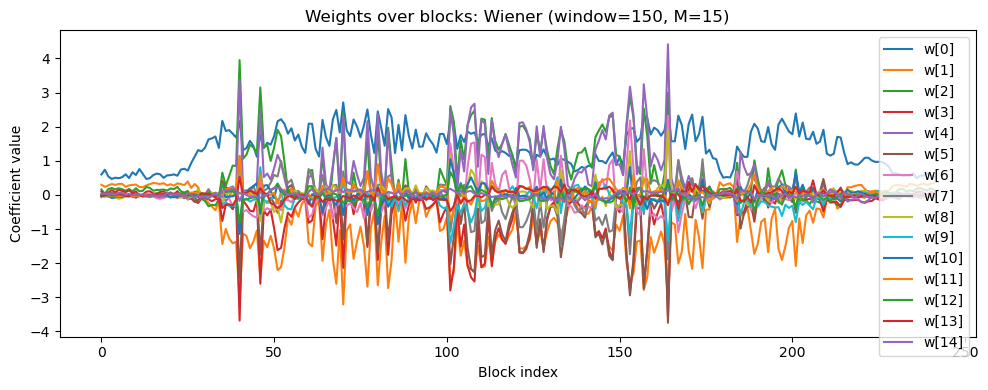

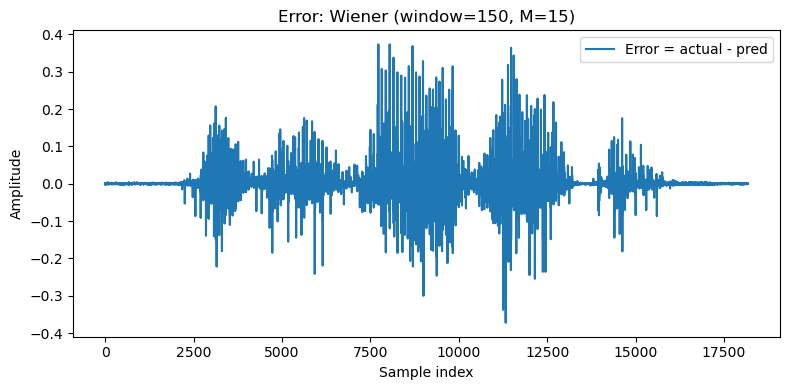

[Speech-Wiener] window=500, M=6, NMSE=0.0500


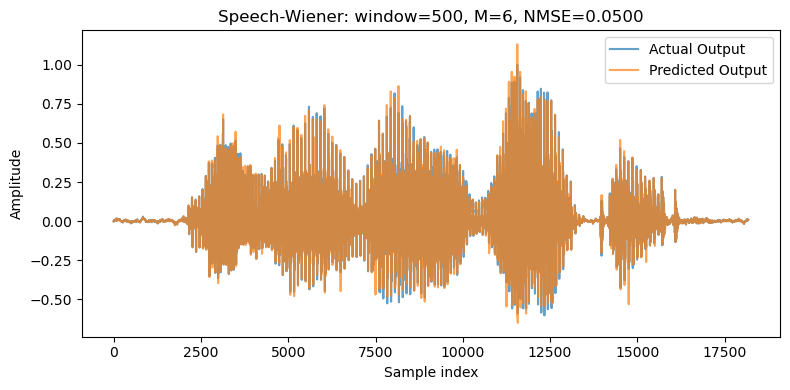

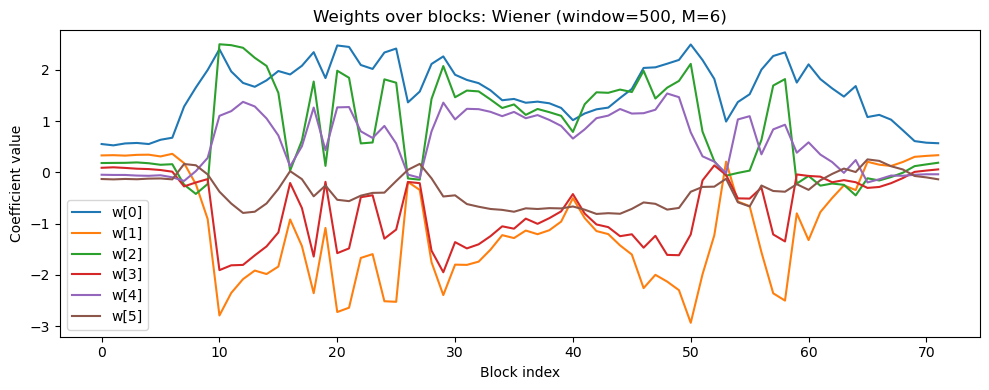

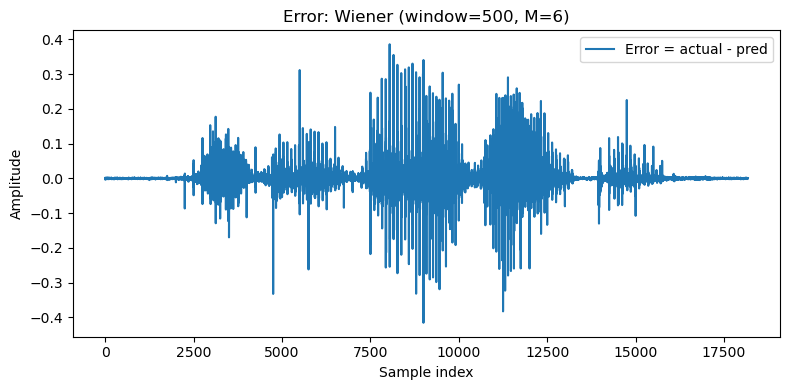

[Speech-Wiener] window=500, M=15, NMSE=0.0340


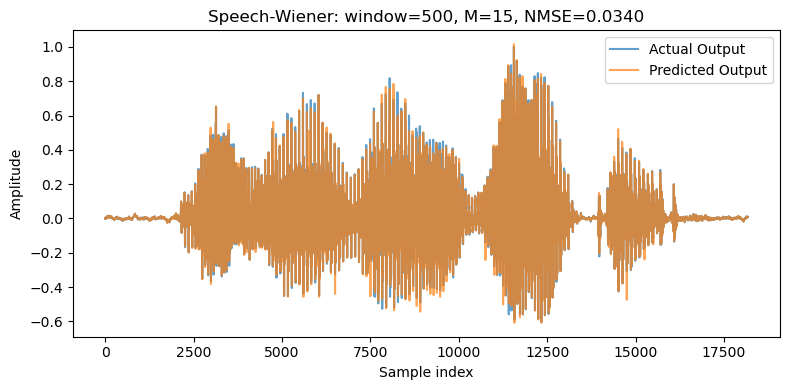

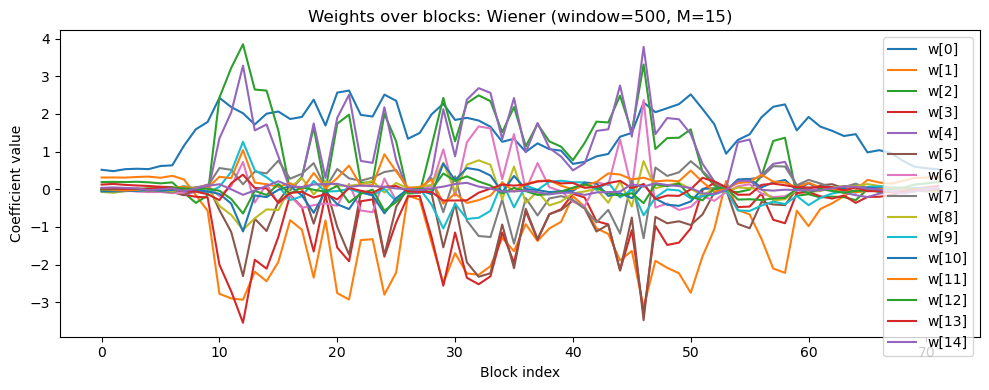

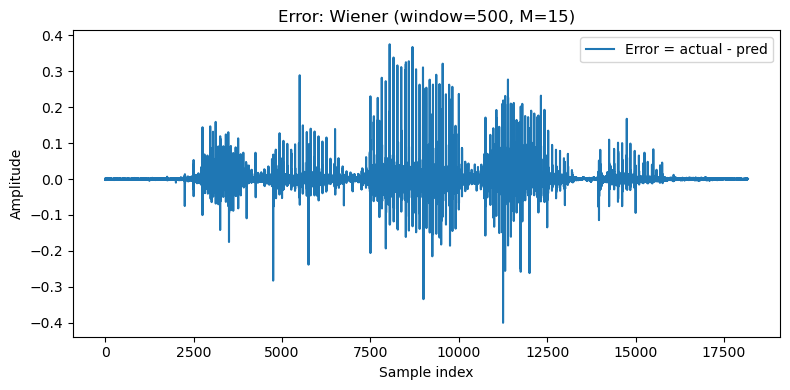


Wrote best predicted speech to: speech_wiener_ws_500_M_15_pred.wav (NMSE=0.0340)


In [13]:
def wiener_predictor_speech_demo():
    """
    Slides over the speech data with 50% overlap for each combination
    of (filter_order, window_size). Stores the predictor output,
    computes NMSE, and shows weight tracks.
    """
    results = []

    for ws in speech_window_sizes:
        for M in speech_filter_orders:
            # Run block-wise Wiener predictor
            y_pred, w_history = wiener_predictor_blockwise(
                x=speech_data,
                window_size=ws,
                M=M,
                overlap=0.5,   # 50% overlap
                lam=1e-6       # or choose a different lambda if desired
            )
            
            # Compute NMSE
            err = speech_data - y_pred
            nmse = np.mean(err**2) / (np.mean(speech_data**2) + 1e-14)
            print(f"[Speech-Wiener] window={ws}, M={M}, NMSE={nmse:.4f}")
            
            # Save result, including the predicted signal
            # so we can later pick the best NMSE run and its y_pred
            results.append({
                "ws": ws,
                "M": M,
                "nmse": nmse,
                "w_history": w_history,
                "y_pred": y_pred
            })
            
            # Plot predicted vs. actual
            figname = f"speech_wiener_ws_{ws}_M_{M}.png"
            plot_and_save(
                sig_true=speech_data,
                sig_pred=y_pred,
                figname=figname,
                title=(f"Speech-Wiener: window={ws}, M={M}, NMSE={nmse:.4f}")
            )
            
            # Plot weight tracks
            w_hist_arr = np.array(w_history).T  # shape = (M, num_blocks)
            plt.figure(figsize=(10,4))
            for m in range(M):
                plt.plot(w_hist_arr[m,:], label=f"w[{m}]")
            plt.title(f"Weights over blocks: Wiener (window={ws}, M={M})")
            plt.xlabel("Block index")
            plt.ylabel("Coefficient value")
            plt.legend()
            fig_wtrack = f"speech_wiener_wtrack_ws_{ws}_M_{M}.png"
            plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, fig_wtrack), dpi=150)
            plt.show()

            # Plot the error signal
            plt.figure(figsize=(8,4))
            plt.plot(err, label="Error = actual - pred")
            plt.title(f"Error: Wiener (window={ws}, M={M})")
            plt.xlabel("Sample index")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return results

# Run the Wiener predictor for speech
wiener_results_speech = wiener_predictor_speech_demo()

# Now pick the best NMSE scenario and save its predicted signal to a WAV file
best_nmse_so_far = 1e15
best_ws_so_far = None
best_M_so_far = None
best_y_pred_so_far = None

for item in wiener_results_speech:
    nmse = item["nmse"]
    if nmse < best_nmse_so_far:  # pick the lowest NMSE
        best_nmse_so_far = nmse
        best_ws_so_far = item["ws"]
        best_M_so_far = item["M"]
        best_y_pred_so_far = item["y_pred"]  # store the predicted signal

if best_y_pred_so_far is not None:
    # We'll reshape to (N,1) to be safe.
    best_y_pred_mono = best_y_pred_so_far.reshape(-1, 1)

    out_fname = f"speech_wiener_ws_{best_ws_so_far}_M_{best_M_so_far}_pred.wav"
    sf.write(out_fname, best_y_pred_mono, fs_speech)
    print(f"\nWrote best predicted speech to: {out_fname} "
          f"(NMSE={best_nmse_so_far:.4f})")
else:
    print("No results found to save.")


#### A) Model Complexity Relevance

##### Order

Based on the outputs, it did not seem that there was a significant effect in the model's prediction ability. The order of 6 and 15 achieved visually equivalent solutions, and the order 15 achieved a slightly better NMSE value. In fact, the NMSE improved on a scale roughly $$ \frac{\text{NMSE2}}{\text{NMSE1}} \propto \sqrt{\frac{M_1}{M_2}}$$ This trend indicates that model order returns are diminishing as the explained variance is captured more, which makes sense in the context of these solutions.

##### Data Window

Similar to the model's order, there was not a significant effect in the model's prediciton ability. Again, the window sizes of 150 and 500 achieved visually equivalent solutions which is also shocking given the extensive amount of extra data. The NMSE barely improved, definitely at a rate less than the model order's contribution, indicating that data availability poses an even stronger diminishing effect. I suspect that improvements due to data window size can be attributed to the precision in our estimation alone.

##### Error History

Based on the error history, it seems as though major transitions in the audio raised issues for the model, spiking the error significantly. This makes sense as the audio is non-stationary, as evident by the consistently changing weight tracks.

##### Audio Description

Based on the output audio, the Wiener Filter seems to accurately predict the audio. The main conflict is that the output sounds fairly noisy in comparison to the original audio. Based on the consistently changing weights due to nonstationarity, it is evident that the output would be noisy, however it was clear that the model's weights were capturing the different transitions in audio, as the learned weights reflected each segment.

##### Nonstationary Observation

Overall, the model performed well and seemingly caught the trends it was supposed to. This may indicate that the windows of time can actually predict the audio. However, it is clear that the model is incapable of learning the entire data, only each window as evident by the weight tracks.

### Least Mean Square Filter

[Speech-LMS] M=6, best_eta=0.01, NMSE=0.3537


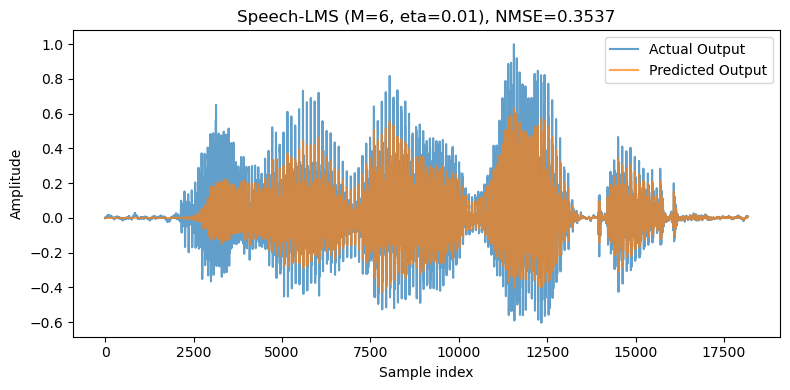

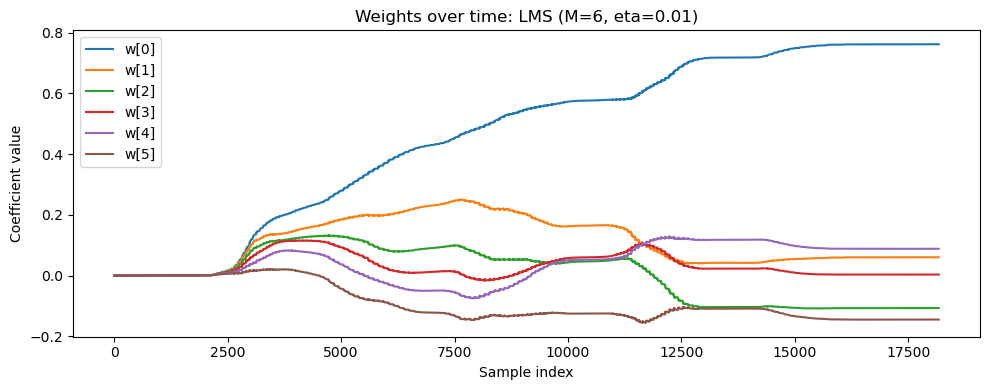

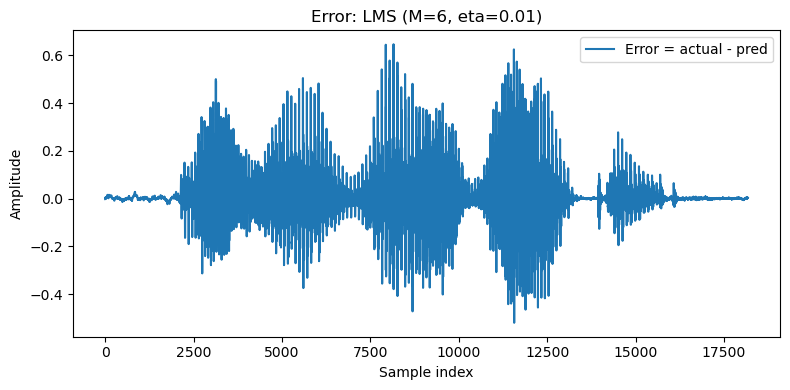

[Speech-LMS] M=15, best_eta=0.01, NMSE=0.2790


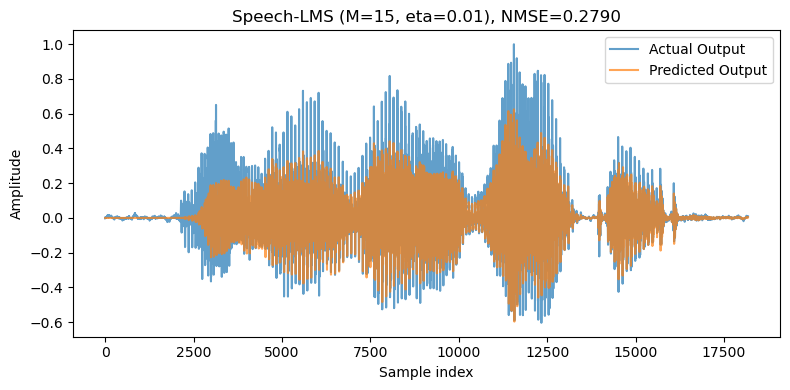

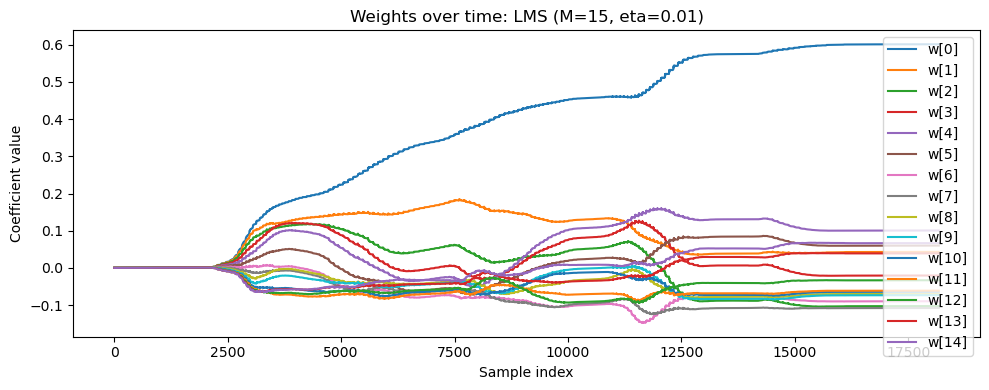

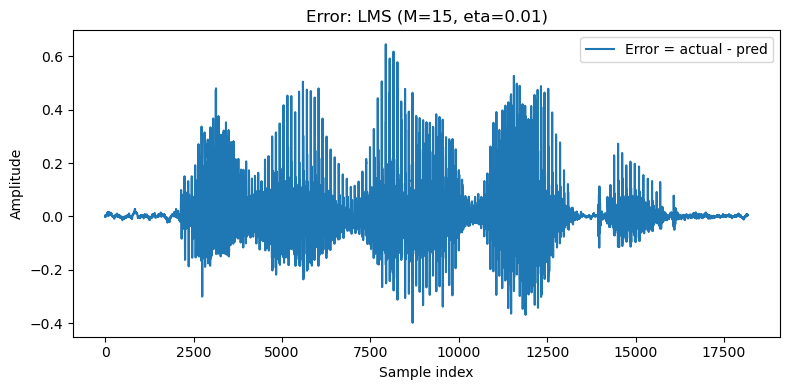


Wrote best predicted speech to: speech_lms_M_15_eta_0.01_pred.wav (NMSE=0.2790)


In [14]:
def lms_predictor_speech_demo():
    """
    Demonstrates LMS for speech prediction. We do NOT do block adaptation
    but a single-pass approach. We'll re-run for each (M, step_size) pair,
    or cross-validate step_size if we want.

    We'll store weight tracks to compare with Wiener solution.
    """
    # We can do the same filter orders: 6, 15
    # We'll pick a step size or do cross-validation. For demonstration, let's pick a small set of etas.
    possible_etas = [1e-4, 1e-3, 1e-2]  # adjust to your preference
    results = []

    for M in speech_filter_orders:
        # Optionally do cross-validation for mu (eta)
        best_eta = possible_etas[0]
        best_nmse = 1e15

        # Let's do a simple hold-out approach: train on first 80%, test on last 20%
        split = int(0.8 * N_speech)
        x_train = speech_data[:split]
        x_test  = speech_data[split:]
        
        for eta_c in possible_etas:
            # We'll track weights as we adapt on x_train
            w = np.zeros(M)
            y_pred_train = np.zeros_like(x_train)
            for n in range(len(x_train) - 1):
                x_vec = np.zeros(M)
                for mm in range(M):
                    idx = n - mm
                    if idx >= 0:
                        x_vec[mm] = x_train[idx]
                y_hat = np.dot(w, x_vec)
                y_pred_train[n + 1] = y_hat
                e = x_train[n + 1] - y_hat
                w += eta_c * e * x_vec

            # Evaluate MSE on x_test by freezing w
            y_pred_test = np.zeros_like(x_test)
            for i in range(len(x_test) - 1):
                x_vec = np.zeros(M)
                for mm in range(M):
                    idx = i - mm
                    if idx >= 0:
                        x_vec[mm] = x_test[idx]
                y_hat = np.dot(w, x_vec)
                y_pred_test[i + 1] = y_hat
                # freeze w for validation
                # e = x_test[i+1] - y_hat
                # w += eta_c * e * x_vec  # if continuing adaptation

            # Compute NMSE on test
            err_test = x_test - y_pred_test
            nmse_test = np.mean(err_test**2) / (np.mean(x_test**2) + 1e-14)
            if nmse_test < best_nmse:
                best_nmse = nmse_test
                best_eta = eta_c
        
        # Now run entire data with best_eta, store weight tracks
        w = np.zeros(M)
        y_pred_full = np.zeros_like(speech_data)
        w_track = []
        for n in range(N_speech - 1):
            x_vec = np.zeros(M)
            for mm in range(M):
                idx = n - mm
                if idx >= 0:
                    x_vec[mm] = speech_data[idx]
            y_hat = np.dot(w, x_vec)
            y_pred_full[n + 1] = y_hat
            e = speech_data[n + 1] - y_hat
            w += best_eta * e * x_vec
            w_track.append(w.copy())

        # Final NMSE over entire speech
        err_full = speech_data - y_pred_full
        nmse_full = np.mean(err_full**2) / (np.mean(speech_data**2) + 1e-14)
        print(f"[Speech-LMS] M={M}, best_eta={best_eta}, NMSE={nmse_full:.4f}")

        # Save result (including the predicted speech)
        results.append((M, best_eta, nmse_full, w_track, y_pred_full))

        # Plot predicted vs. actual
        figname = f"speech_lms_M_{M}_eta_{best_eta}.png"
        plot_and_save(
            sig_true=speech_data,
            sig_pred=y_pred_full,
            figname=figname,
            title=(f"Speech-LMS (M={M}, eta={best_eta}), NMSE={nmse_full:.4f}")
        )

        # Weight tracks
        w_track_arr = np.array(w_track).T  # shape = (M, N_speech-1)
        plt.figure(figsize=(10,4))
        for m in range(M):
            plt.plot(w_track_arr[m,:], label=f"w[{m}]")
        plt.title(f"Weights over time: LMS (M={M}, eta={best_eta})")
        plt.xlabel("Sample index")
        plt.ylabel("Coefficient value")
        plt.legend()
        fig_wtrack = f"speech_lms_wtrack_M_{M}_eta_{best_eta}.png"
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, fig_wtrack), dpi=150)
        plt.show()

        # Plot the errors
        plt.figure(figsize=(8,4))
        plt.plot(err_full, label="Error = actual - pred")
        plt.title(f"Error: LMS (M={M}, eta={best_eta})")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return results

lms_results_speech = lms_predictor_speech_demo()

# Now pick the best NMSE scenario and save its predicted signal to a WAV file
best_nmse_so_far = 1e15
best_M_so_far = None
best_eta_so_far = None
best_y_pred_so_far = None

for (M, eta, nmse, w_hist, y_pred_full) in lms_results_speech:
    if nmse < best_nmse_so_far:
        best_nmse_so_far = nmse
        best_M_so_far = M
        best_eta_so_far = eta
        best_y_pred_so_far = y_pred_full.copy()

if best_y_pred_so_far is not None:
    # Reshape to (N, 1) for a mono WAV
    best_y_pred_mono = best_y_pred_so_far.reshape(-1, 1)
    out_fname = f"speech_lms_M_{best_M_so_far}_eta_{best_eta_so_far}_pred.wav"
    sf.write(out_fname, best_y_pred_mono, fs_speech)
    print(f"\nWrote best predicted speech to: {out_fname} (NMSE={best_nmse_so_far:.4f})")
else:
    print("No results found to save.")


#### Determine Optimal $\eta$ via Cross-Validation

#### A) Model Complexity Relevance

##### Order

Based on the outputs, it did not seem that there was a significant effect in the model's prediction ability. The order of 6 and 15 achieved visually equivalent solutions, and the order 15 achieved a slightly better NMSE value. In fact, the NMSE improved on a scale roughly $$ \frac{\text{NMSE2}}{\text{NMSE1}} \propto \sqrt{\frac{M_1}{M_2}}$$ This trend indicates that model order returns are diminishing as the explained variance is captured more, which makes sense in the context of these solutions.

##### Error History

Based on the error history, it seems as though major transitions in the audio raised issues for the model, spiking the error significantly. This makes sense as the audio is non-stationary, as evident by the consistently changing weight tracks, however it seemed that the learning process was relatively stable indicating that the model is learning what IS stationary about the data. Another point of interest was that the error history started out larger due to the model's online learning - it did not immediately learn the necessary magnitude to match the signal's, but it did seem to capture the trends well.

#### B) Comparison

The LMS algorithm seemingly learns a specific set of values, which is actually very different from the Wiener Filter which does stay relatively the same through time, but definitely adjusts more dramatically. In my opinion, the LMS algorithm sounds less noisy than the Wiener Filter, indicating that it may be more robust to noise which is sensible given its online learning process and the weight tracks - however, the algorithm did seemingly struggle with learning the correct loudness at first, but adjusted and stabilized correctly towards the end of the audio which can also be seen in the decreasing nature of the error plot's amplitude. 